<a href="https://colab.research.google.com/github/rafiulislamri/Deep-CNN-mnist-Digit-Recognizer-v2-g-----Training-06/blob/main/mnistV2(G).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub plotly -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [2]:
import kagglehub

print("Downloading MNIST dataset...")
path = kagglehub.dataset_download("oddrationale/mnist-in-csv")
print("Path to dataset files:", path)

# Load training and test data
train_data = pd.read_csv(f"{path}/mnist_train.csv")
test_data = pd.read_csv(f"{path}/mnist_test.csv")

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

100%|██████████| 15.2M/15.2M [00:00<00:00, 129MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/oddrationale/mnist-in-csv/versions/2
Training data shape: (60000, 785)
Test data shape: (10000, 785)



=== Dataset Overview ===
Training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB
None

First few labels: [5 0 4 1 9 2 1 3 1 4]


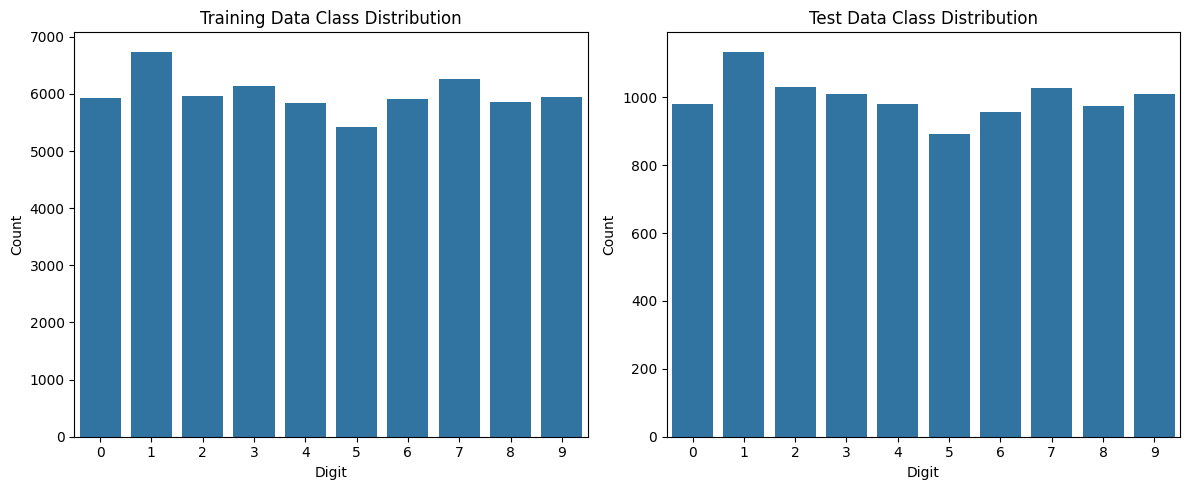


Sample Training Images:


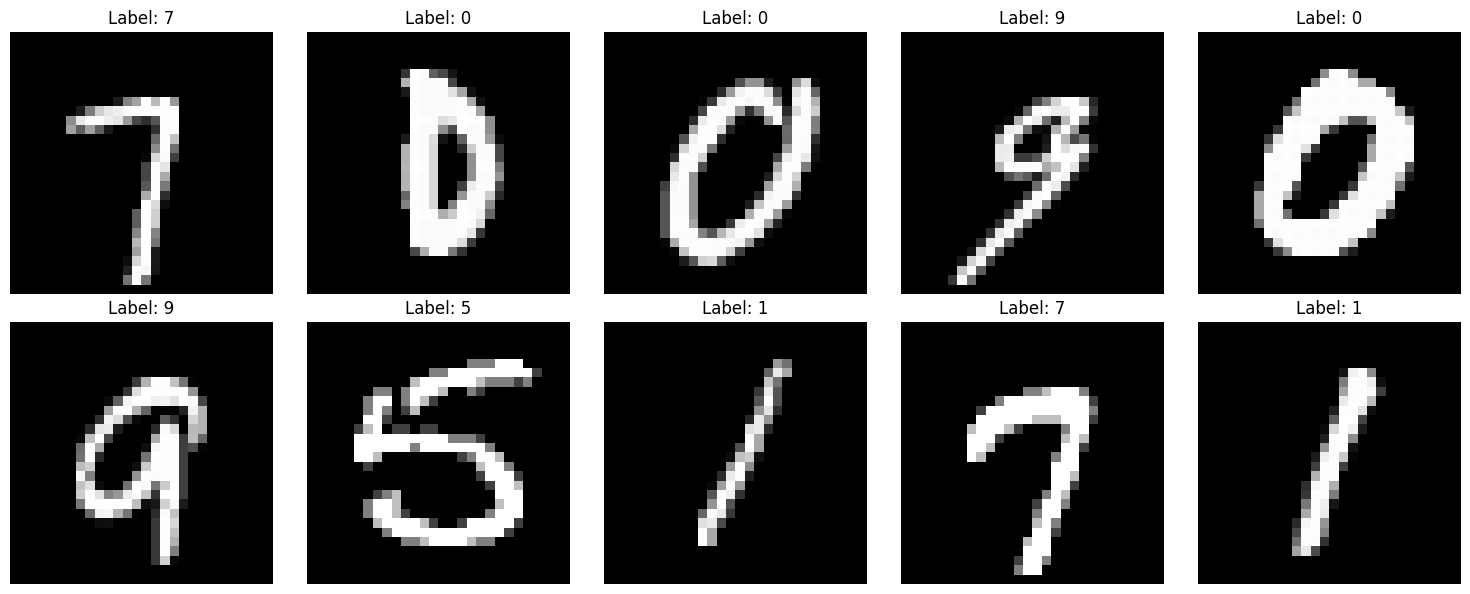

In [3]:
print("\n=== Dataset Overview ===")
print("Training data info:")
print(train_data.info())
print(f"\nFirst few labels: {train_data['label'].head(10).values}")

# Check class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=train_data['label'])
plt.title('Training Data Class Distribution')
plt.xlabel('Digit')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x=test_data['label'])
plt.title('Test Data Class Distribution')
plt.xlabel('Digit')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Display some sample images
def display_sample_images(data, num_samples=10):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(0, len(data))
        label = data.iloc[idx, 0]
        pixels = data.iloc[idx, 1:].values.reshape(28, 28)

        axes[i].imshow(pixels, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("\nSample Training Images:")
display_sample_images(train_data)

In [4]:
print("\n=== Data Preprocessing ===")

# Separate features and labels
X_train = train_data.iloc[:, 1:].values
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data for CNN (28x28 pixels, 1 channel)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

print(f"After reshaping - X_train shape: {X_train.shape}")
print(f"After reshaping - X_test shape: {X_test.shape}")

# Convert labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train, 10)
y_test_categorical = to_categorical(y_test, 10)

print(f"y_train_categorical shape: {y_train_categorical.shape}")


=== Data Preprocessing ===
X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)
After reshaping - X_train shape: (60000, 28, 28, 1)
After reshaping - X_test shape: (10000, 28, 28, 1)
y_train_categorical shape: (60000, 10)


In [5]:
print("\n=== Building CNN Model ===")

def create_cnn_model():
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.25),

        # Fully Connected Layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model

model = create_cnn_model()

# Display model architecture
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


=== Building CNN Model ===


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781,354 (6.80 MB)

 Trainable params: 1,780,138 (6.79 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

In [7]:
print("\n=== Training Model ===")

history = model.fit(
    X_train, y_train_categorical,
    batch_size=128,
    epochs=8,
    validation_data=(X_test, y_test_categorical),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


=== Training Model ===
Epoch 1/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 318s 666ms/step - accuracy: 0.7803 - loss: 0.7394 - val_accuracy: 0.5259 - val_loss: 1.7482 - learning_rate: 0.0010
Epoch 2/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 321s 665ms/step - accuracy: 0.9737 - loss: 0.0880 - val_accuracy: 0.9890 - val_loss: 0.0318 - learning_rate: 0.0010
Epoch 3/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 310s 660ms/step - accuracy: 0.9798 - loss: 0.0666 - val_accuracy: 0.9908 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 4/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 313s 667ms/step - accuracy: 0.9827 - loss: 0.0561 - val_accuracy: 0.9904 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 5/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 312s 664ms/step - accuracy: 0.9864 - loss: 0.0457 - val_accuracy: 0.9888 - val_loss: 0.0355 - learning_rate: 0.0010
Epoch 6/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 329s 679ms/step - accuracy: 0.9889 - loss: 0.0376 - val_accuracy: 0.9933 - val_loss: 0.0233 - learning_rate: 0.0010
Epoch 7/8
469/469 ━━━━━━━━━━━━━━━━━━━━ 315s 67


=== Model Evaluation ===
Final Training Accuracy: 0.9951
Final Test Accuracy: 0.9942


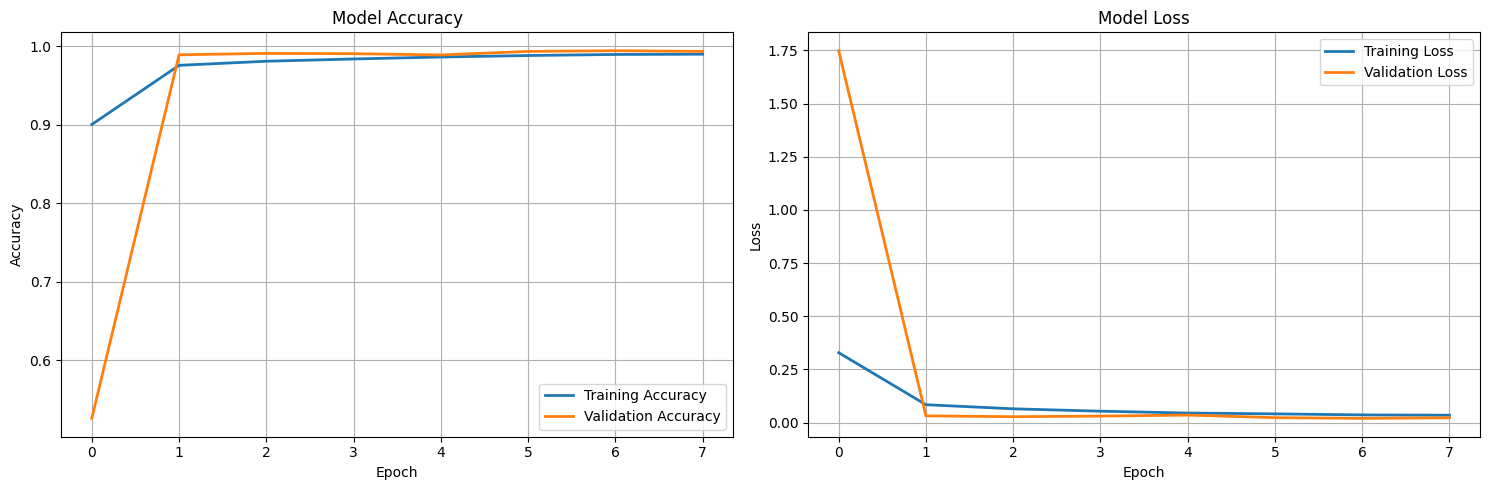

In [8]:
print("\n=== Model Evaluation ===")

# Get final training and test accuracy
train_loss, train_accuracy = model.evaluate(X_train, y_train_categorical, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical, verbose=0)

print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


=== Making Predictions ===
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



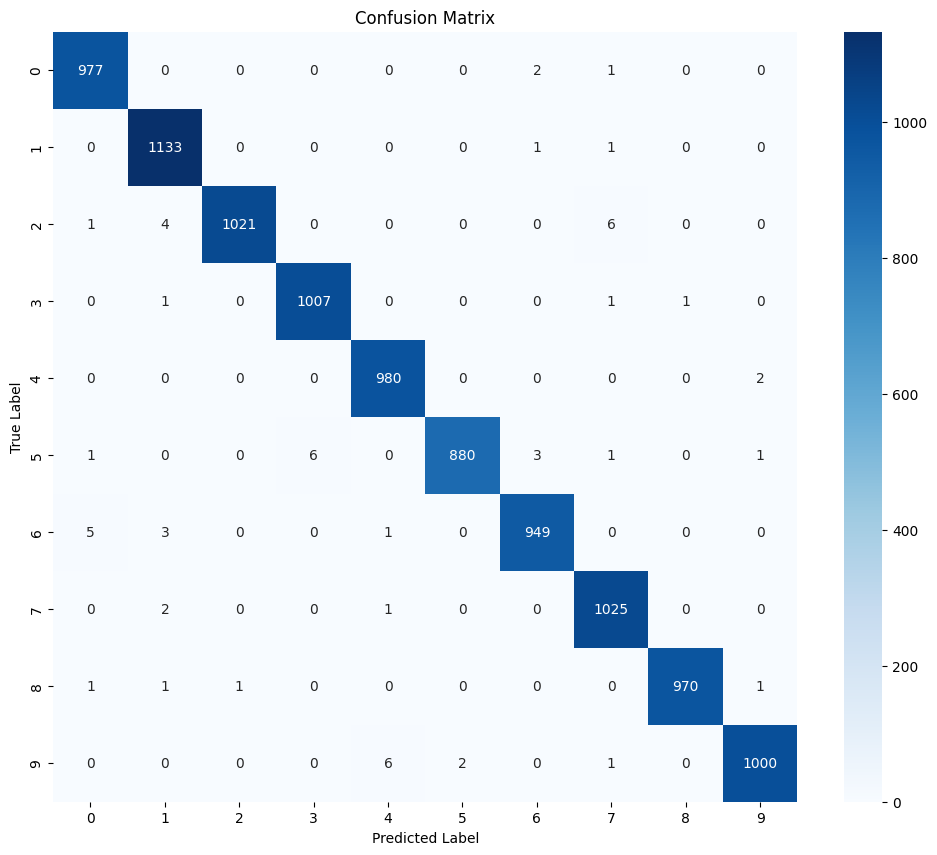

In [9]:
print("\n=== Making Predictions ===")

# Predict on test set
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



=== Visual Prediction Analysis ===
Correct predictions: 9942/10000 (99.42%)
Incorrect predictions: 58/10000 (0.58%)

Sample Correct Predictions:


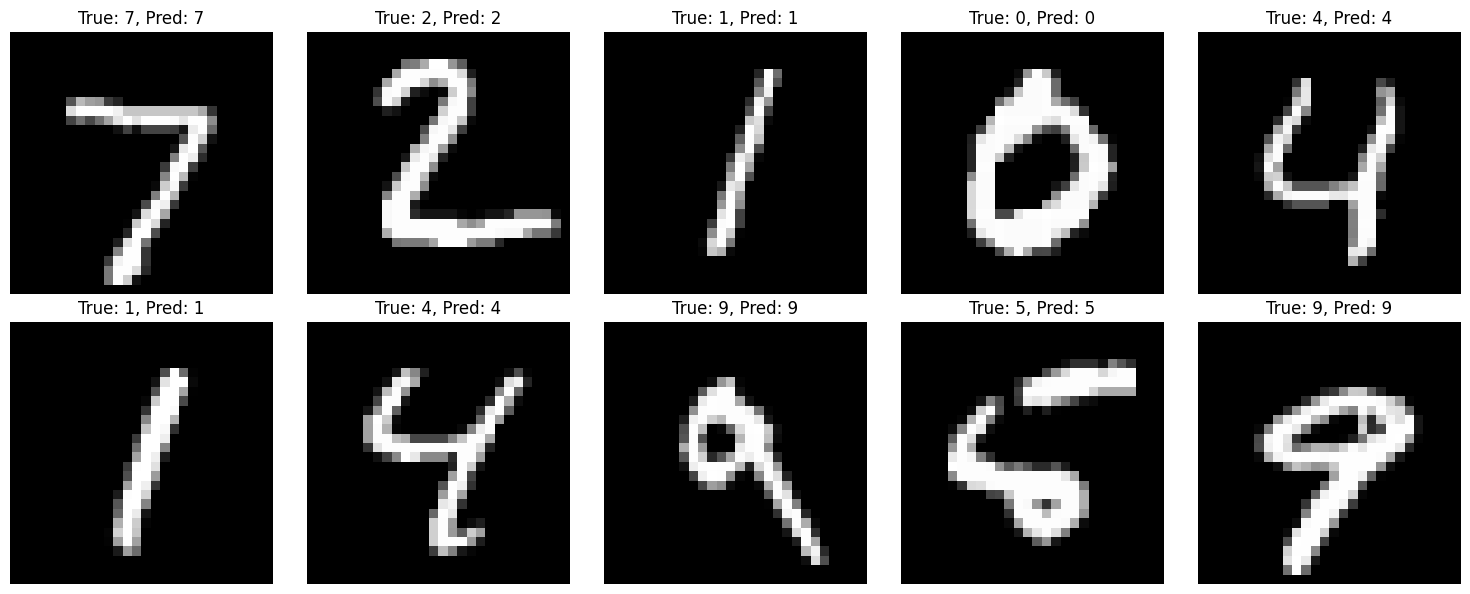


Sample Incorrect Predictions:


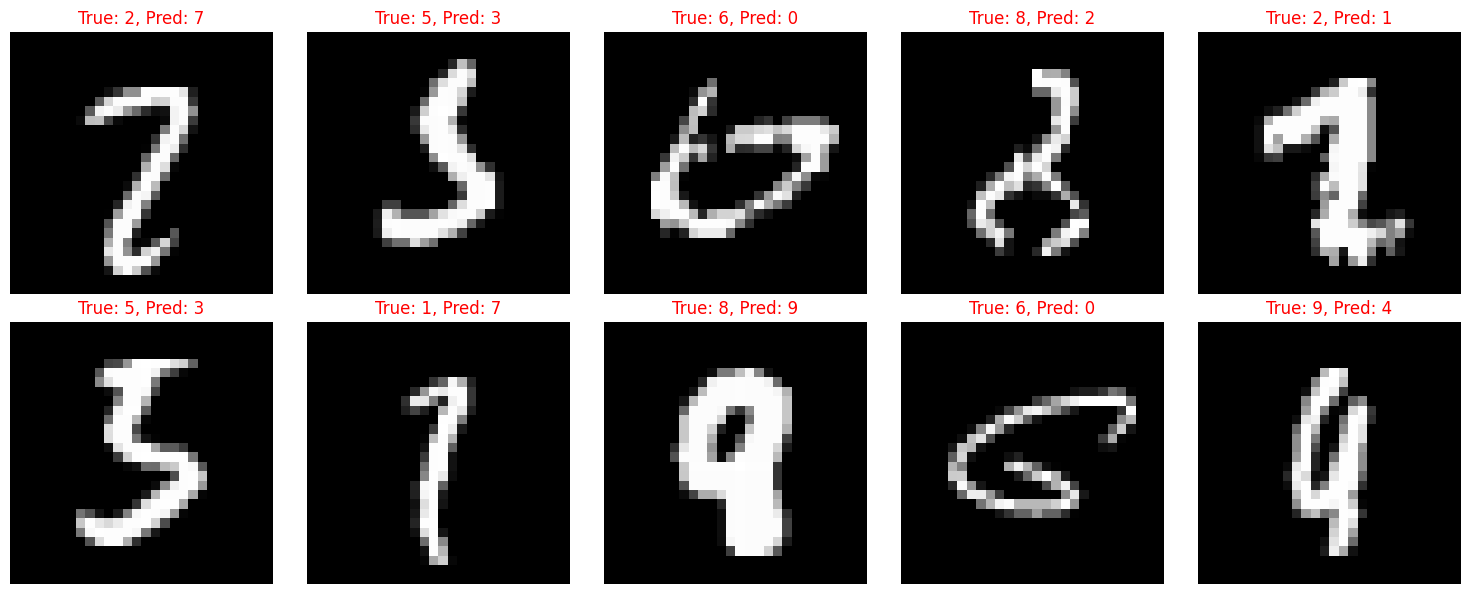

In [10]:
print("\n=== Visual Prediction Analysis ===")

def visualize_predictions(X_test, y_test, y_pred, num_samples=10):
    # Find correct and incorrect predictions
    correct_indices = np.where(y_pred == y_test)[0]
    incorrect_indices = np.where(y_pred != y_test)[0]

    print(f"Correct predictions: {len(correct_indices)}/{len(y_test)} ({len(correct_indices)/len(y_test)*100:.2f}%)")
    print(f"Incorrect predictions: {len(incorrect_indices)}/{len(y_test)} ({len(incorrect_indices)/len(y_test)*100:.2f}%)")

    # Display correct predictions
    if len(correct_indices) > 0:
        print("\nSample Correct Predictions:")
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.ravel()

        for i in range(min(num_samples, len(correct_indices))):
            idx = correct_indices[i]
            axes[i].imshow(X_test[idx].reshape(28, 28), cmap='gray')
            axes[i].set_title(f'True: {y_test[idx]}, Pred: {y_pred[idx]}')
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

    # Display incorrect predictions
    if len(incorrect_indices) > 0:
        print("\nSample Incorrect Predictions:")
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.ravel()

        for i in range(min(num_samples, len(incorrect_indices))):
            idx = incorrect_indices[i]
            axes[i].imshow(X_test[idx].reshape(28, 28), cmap='gray')
            axes[i].set_title(f'True: {y_test[idx]}, Pred: {y_pred[idx]}', color='red')
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

visualize_predictions(X_test, y_test, y_pred)


=== Interactive Testing ===
Testing random samples from test set:

Sample 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


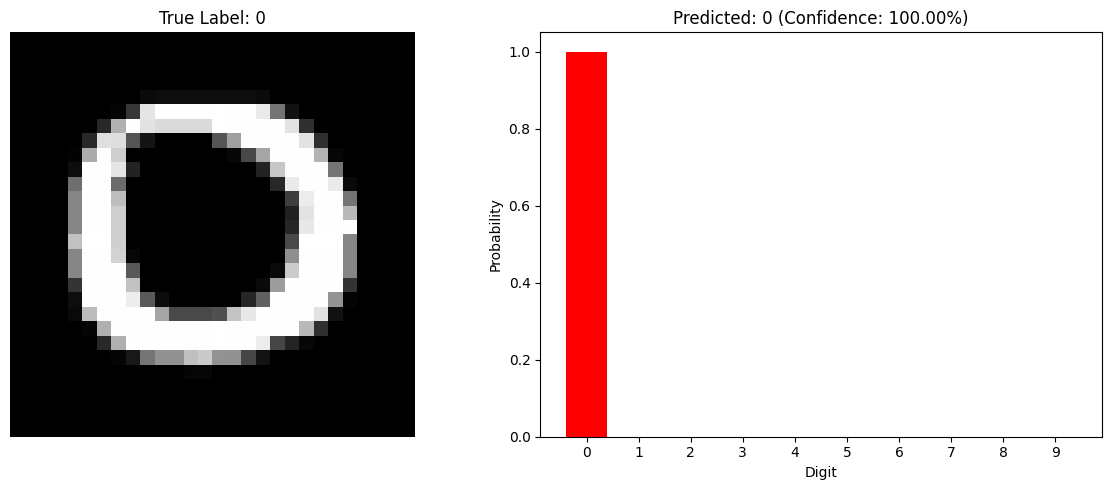

Result: ✓ CORRECT - True: 0, Predicted: 0, Confidence: 100.00%

Sample 2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


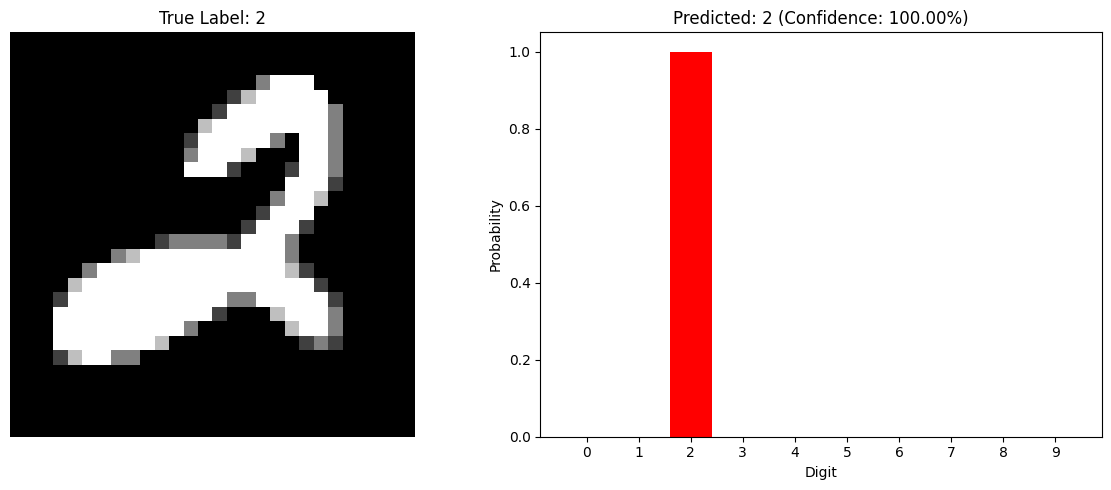

Result: ✓ CORRECT - True: 2, Predicted: 2, Confidence: 100.00%

Sample 3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


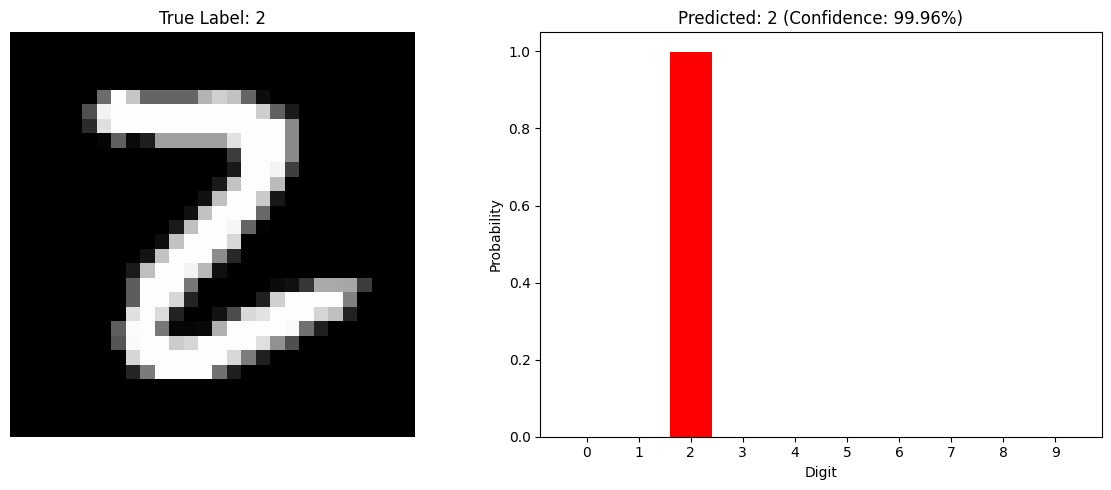

Result: ✓ CORRECT - True: 2, Predicted: 2, Confidence: 99.96%

Sample 4:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


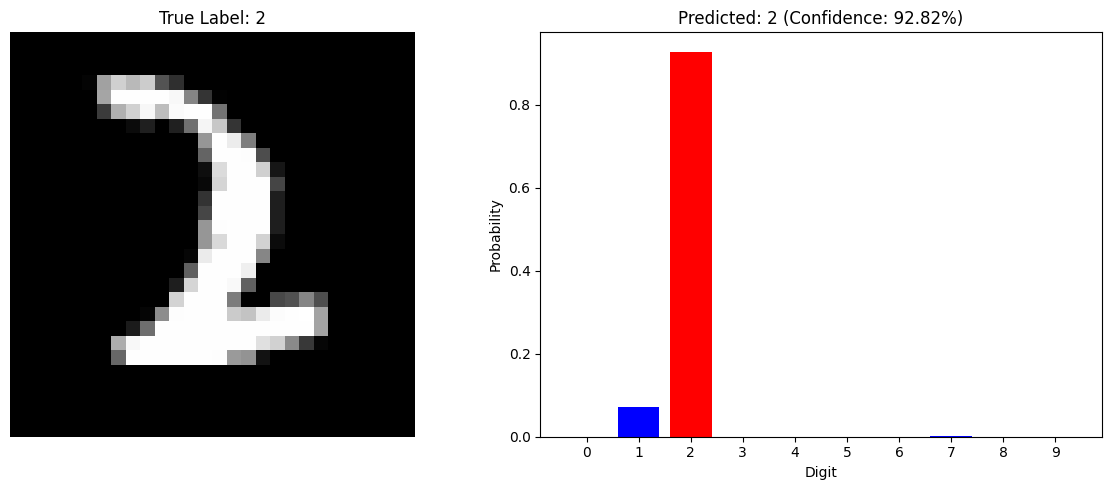

Result: ✓ CORRECT - True: 2, Predicted: 2, Confidence: 92.82%

Sample 5:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


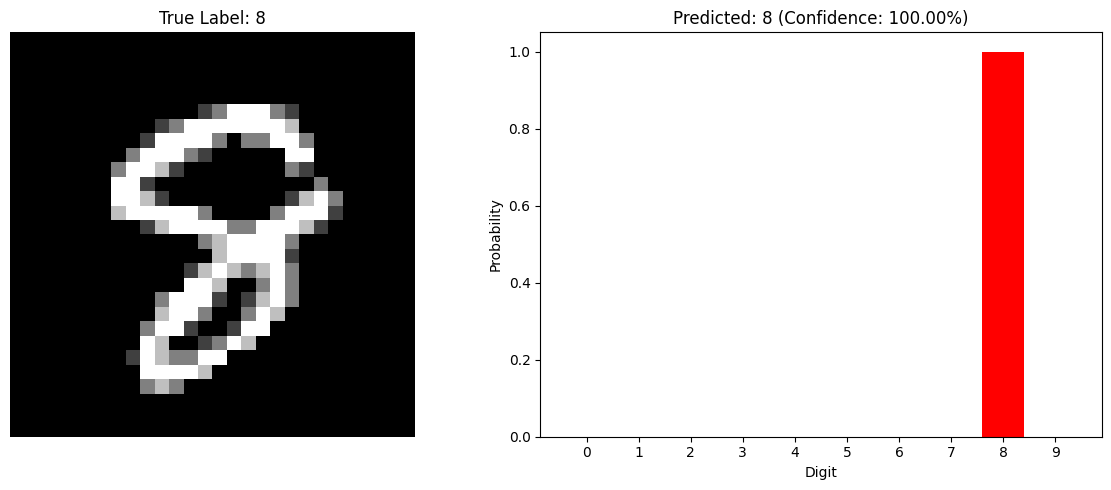

Result: ✓ CORRECT - True: 8, Predicted: 8, Confidence: 100.00%


In [11]:
print("\n=== Interactive Testing ===")

def test_single_prediction(model, X_test, y_test, index=None):
    if index is None:
        index = np.random.randint(0, len(X_test))

    image = X_test[index]
    true_label = y_test[index]

    # Make prediction
    prediction = model.predict(np.expand_dims(image, axis=0))
    predicted_label = np.argmax(prediction)
    confidence = np.max(prediction)

    # Display results
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Image
    axes[0].imshow(image.reshape(28, 28), cmap='gray')
    axes[0].set_title(f'True Label: {true_label}')
    axes[0].axis('off')

    # Prediction probabilities
    classes = range(10)
    axes[1].bar(classes, prediction[0], color=['red' if i == predicted_label else 'blue' for i in classes])
    axes[1].set_xlabel('Digit')
    axes[1].set_ylabel('Probability')
    axes[1].set_title(f'Predicted: {predicted_label} (Confidence: {confidence:.2%})')
    axes[1].set_xticks(classes)

    plt.tight_layout()
    plt.show()

    return predicted_label, confidence, true_label

# Test random samples
print("Testing random samples from test set:")
for i in range(5):
    print(f"\nSample {i+1}:")
    pred, conf, true = test_single_prediction(model, X_test, y_test)
    print(f"Result: {'✓ CORRECT' if pred == true else '✗ WRONG'} - True: {true}, Predicted: {pred}, Confidence: {conf:.2%}")

In [12]:
print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*50)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

# Calculate additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"🎯 Weighted Precision: {precision:.4f}")
print(f"🎯 Weighted Recall: {recall:.4f}")
print(f"🎯 Weighted F1-Score: {f1:.4f}")


FINAL MODEL PERFORMANCE SUMMARY
Final Test Accuracy: 0.9942 (99.42%)
Training Accuracy: 0.9951 (99.51%)
Total Epochs Trained: 8
Best Validation Accuracy: 0.9942
🎯 Weighted Precision: 0.9942
🎯 Weighted Recall: 0.9942
🎯 Weighted F1-Score: 0.9942


In [13]:
print("\n=== Saving Model ===")
model.save('mnist_cnn_model.h5')
print("Model saved as 'mnist_cnn_model.h5'")


=== Saving Model ===
Model saved as 'mnist_cnn_model.h5'
